In [217]:
import pandas as pd
import numpy as np
import random
import math
from parse import *
import os
import sklearn
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
#%matplotlib auto
import matplotlib.image as mpimg 
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection
from collections import defaultdict
import datetime
from datetime import timedelta
import argparse
import helper


In [218]:
'''
cmd不方便调试，就建了一个类充当参数输入的接口
'''
class Myclass():
    MinCountOfPoints=6 #这里我没改，因为分长时间和短时间计算时，我手动一起调了（详见最后一个part）
    MinCountOfPointsForAll=-1
    SizeOfGrid='1' # 不需要调 
    figure='floorplan01.png'
    path='./results_tag0/'
    res='./figures/'
    bySecond=False
    IntervalOfMinutesOrSeconds=1 # 1分钟 1个点  
    setConfig=True #False

arguments=Myclass()


In [219]:

##########################################
# Choose Family
##########################################
family_config = helper.chooseFamily()

max_x = family_config.size[1]
min_x = family_config.size[0]
max_y = family_config.size[3]
min_y = family_config.size[2]


unit = float(arguments.SizeOfGrid)  #网格单元长宽m
column_num = int((max_x-min_x)//unit)
row_num = int((max_y-min_y)//unit)
map_img = mpimg.imread(arguments.figure)

# time epsilon to select the data point
epsilon = 10 #timedelta(minutes=10)
min_count = arguments.MinCountOfPoints

# define time
year = 2022
input_path = arguments.path
res_path = arguments.res
C = 0












==>Familiy choices :<==
1 :ParentsOfSun
2 :UncleOfSun
3 :AuntOfSun
Family of ParentsOfSun is chosen!

Trace familes:
	ParentsOfSun
	size of house : [-2.665, 13.505, -2.2, 10.44]
		Scenario=Shift
			zone 1: OutDoor
				{ x : [-1000.0,-0.0],y : [-1000.0,1000.0] => Delete
			zone 2: OutCanteen
				{ x : [-0.415,1.17],y : [6.773,1000.0] => MoveToDown
			zone kitchen: InKitchen
				{ x : [1.17,3.6],y : [6.785,10.44] => MoveToLeftLinearly
			zone 3: OutKitchen
				{ x : [1.17,3.6],y : [10.44,1000.0] => MoveToDown
			zone 4: OutKitchen
				{ x : [3.6,1000.0],y : [10.44,1000.0] => MoveToLeftDown
			zone 5: OutCanteen
				{ x : [3.6,1000.0],y : [5.37,6.785] => MoveToLeft
			zone 6: OutBalcony
				{ x : [-0.415,6.8],y : [-1000.0,-2.2] => MoveToUp
			zone 7: OutBedRoom
				{ x : [4.115,1000.0],y : [1.085,5.37] => MoveToLeft


In [220]:
"""
File Path Creation
"""
def createPath(dirName):
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")
 
"""
Grid Generator
"""
def collectData(dict_df,key):
    df = dict_df[key]

    xs = []
    ys = []
    ts = []
    for i in range(len(df['time'])):
        ts.append(df['time'][i])
        xs.append(df['x值'][i])
        ys.append(df['y值'][i])
    c={ "time":ts,"x":xs,'y':ys}
    data= pd.DataFrame(c)
    print("After Collect Data:\n",data)
    return data

##########################################
# Data pre-view
##########################################


##########################################
# Data re-clean
##########################################

"""
Shift the data/position accoding to the prevision and family configuration
"""
def shift(family,df):
    for scenario in family.scenario:
        # make sure that in each scenario
        # there is only one shift linearly
        recordsInRoom = defaultdict(list)
        if scenario.name == "Shift":
            zones = scenario.zones
            for index, row in df.iterrows():
                x = row['x值']
                y = row['y值']
                m = "DoNothing"
                f = -1
                for zone in scenario.zones:
                    if helper.inZone(x,y,zone):
                        m = zone.method
                        if m == "DoNothing":
                            break
                        # print("===============> use:"+m)
                        if m.endswith("Linearly"):
                            recordsInRoom[(m,zone)].append(index)
                        else:
                            f = helper.methods[m]
                            # deal with simple shift
                            x,y = f(x,y,zone)
                            df.at[index,'x值'] = x
                            df.at[index,'y值'] = y
                        break
            # print(recordsInRoom)
            for key in recordsInRoom.keys():
                indices = recordsInRoom[key]
                m = key[0]
                zone = key[1]
                f = helper.methods[m]
                temp_df = df.iloc[indices]
                points = []
                for i,r in temp_df.iterrows():
                    # print(i,r)
                    x = r['x值']
                    y = r['y值']
                    points.append([x,y])
                new_points = f(points,zone)
                for i in range(len(indices)):
                    index = indices[i]
                    df.at[index,'x值'] = new_points[i][0]
                    df.at[index,'y值'] = new_points[i][1]
        else:
            continue
    return df

def collectDataAllInOne(df):
    xs = []
    ys = []
    ts = []
    for i in range(len(df['time'])):
        ts.append(df['time'][i])
        xs.append(df['x值'][i])
        ys.append(df['y值'][i])
    c={ "time":ts,"x":xs,'y':ys}
    data= pd.DataFrame(c)
    print(data)
    return data

def generalID(x,y,column_num,row_num):
    # 若在范围外的点，返回-1
    if x <= min_x or x >= max_x or y <= min_y or y >= max_y:
        return -1
    # 把x范围根据列数等分切割
    column = (max_x - min_x)/column_num
    # 把y范围根据行数数等分切割
    row = (max_y - min_y)/row_num
    # 二维矩阵坐标索引转换为一维ID，即： （列坐标区域（向下取整）+ 1） + （行坐标区域 * 列数）
    return int((x-min_x)//column)+ 1 + int((y-min_y)//row) * column_num

# 去除出门不在家的点
def WashData(data):
    del_list=[]
    for idx,row in data.iterrows():
        if row['label']==67:
            del_list.append(idx)
    for i in del_list:
        data=data.drop(i)
    data.reset_index(inplace=True,drop=True)
    return data

# s=0.5m 门口网格为325
def createGrid(data,figName):
    # add label id to the data    label: 当前数据处于哪一个网格
    data['label'] = data.apply(lambda x: generalID(x['x'], x['y'],column_num,row_num), axis = 1)
    data = WashData(data)

    # count values
    groups = data['label'].value_counts() # 统计网格中的点数
    groups[67]=0   # 删去门口对应的网格中所有点数 （0.5m-325；1m-67）
    
    #print(groups)
    
    # re-organize the grid
    grids = np.zeros([row_num,column_num])
    for i in groups.index:
        r = (i-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
        c = i - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
        # \sqrt{当前网格中的点数/最大网格中的点数}
        grids[r,c] = math.sqrt(groups[i])/math.sqrt(max(groups))  # Do a sqrt to make the heatmap clearer !!!
    
    
    #data.to_excel (res_path+figName+"_dataWithLabel.xls", index = False, header=True)
   
    return groups,grids


def createScatter(data_collection_array,figName):
    fig,ax0 = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    plt.imshow(map_img,extent=[min_x-0.1,max_x,min_y-0.1,max_y]) # 0.3 is used to balance the influence of wight space suround the image
    #ax1 = fig.add_axes()
    ax0.scatter(data_collection_array[:,0],data_collection_array[:,1],s=20)
    fig.savefig(res_path+figName+"_scatter.png",dpi=300)
    plt.close()

"""
Heatmap
"""
def createHeatmap(grids,figName):
    fig, ax = plt.subplots(figsize=(max_x-min_x,max_y-min_y)) #column_num*0.5,row_num*0.5))
    with sns.axes_style("white"):
        ax = sns.heatmap(grids, cmap='Reds',linewidths=.0,alpha=.7,xticklabels =False,square = True,yticklabels =False,mask=(grids==0.),center=0.5)
    ax.invert_yaxis()
    plt.imshow(map_img,zorder = 0,  extent=[-0.1,(max_x-min_x)/unit-0.2,-0.1,(max_y-min_y)/unit-0.3] )#extent=[x_left/unit,x_right/unit,y_down/unit,y_up/unit])
    #plt.show()
    fig.savefig(res_path+figName+".png",dpi=300)
    plt.close()


# Slice By Time
"""
slice by time, which should be continous according to epsilon
"""
def sliceByTime(time_list):
    max_interval = 1 # 该区域内的最长连续停留时间
    times_in_zone = []
    temp_count = 1
    start_time = time_list[0]
    # print("start time :",start_time)
    end_time = time_list[0]
    for i in range(1,len(time_list)):
        t1 = time_list[i-1]
        t2 = time_list[i]
        # time_list中前后两个数据的时间差
        #time_delta = timedelta(hours=t2.hour,minutes=t2.minute) - timedelta(hours=t1.hour,minutes=t1.minute)

        time_delta = t2 - t1
        
        if time_delta.total_seconds()/60 >= epsilon or t2.day != t1.day : #epsilon: # 时间差大于设定值，即在此期间离开该zone，停止计时
            print(t2,t1,time_delta)
            max_interval = max(temp_count,max_interval)
            temp_count = 1
            end_time = t1
            times_in_zone.append([start_time,end_time])
            start_time = t2 # 重设初始时间，开始下一轮计时
        else: # 时间差小于设定值，此期间内一直在该zone中，故计时+1分钟
            temp_count += 1
    max_interval = max(max_interval,temp_count)
    end_time = time_list[i-1]
    times_in_zone.append([start_time,end_time])
    return max_interval,times_in_zone

"""
get the data of corresponding zone
results: key=zone名称 value=最大连续停留时长
details: key=zone名称 value=所有停留时段 times_in_zone=[[start1,end1],[start2,end2],.....]
"""
def getTimeIntervalsForZones(dict_zones,data):
    result = {}
    details = {}
    for zone in dict_zones:
        labels = dict_zones[zone]
        data_zone = data.loc[data['label'].isin(labels)] # 在每个zone网格中的数据
        time_list = data_zone['time'].tolist() # 时间段
        # print("time list:",time_list)
        result[zone],details[zone] = sliceByTime(time_list)

    #print("time interval in all zones", result)
    return result,details

"""
Heatmap by Time
"""
# 无标签的区域分割
def createHeatmapByTime(dict_zones,figName):
    # re-organize the grid
    new_grids = np.zeros([row_num,column_num])
    zone_grids = np.zeros([row_num,column_num])
    for zone in dict_zones.keys():
        for label in dict_zones[zone]:
            r = (label-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
            c = label - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
            new_grids[r,c] = math.sqrt(groups[label])/25 # Do a sqrt to make the map clearer !!!
            zone_grids[r,c] = zone
    #specify size of heatmap
    fig, ax = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    ax = sns.heatmap(new_grids, cmap='YlGnBu',linewidths=0,alpha=0.5,xticklabels =False,square = True,annot=zone_grids,yticklabels =False,mask=(new_grids==0.),center=0.5)
    ax.invert_yaxis()
    #plt.show()
    plt.imshow(map_img,zorder = 0, extent=[-0.1,(max_x-min_x)/unit-0.2,-0.1,(max_y-min_y)/unit-0.3] ) # extent=[x_left/unit,x_right/unit,y_down/unit,y_up/unit])
    fig.savefig(res_path+figName+"_temporal.png",dpi=300)
    plt.close(fig)
    return new_grids

"""
Don't show data on the heatmap by time
"""
# 有标签的区域分割
def createHeatmapByTime2(new_grids,figName):
    fig, ax = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    ax = sns.heatmap(new_grids, cmap='YlGnBu',linewidths=0,alpha=0.5,xticklabels =False,square = True,annot=False,yticklabels =False,mask=(new_grids==0.),center=0.5)
    ax.invert_yaxis()
    #plt.show()
    plt.imshow(map_img,zorder = 0, extent= [-0.1,(max_x-min_x)/unit-0.2,-0.1,(max_y-min_y)/unit-0.3])# [x_left/unit,x_right/unit,y_down/unit,y_up/unit])
    fig.savefig(res_path+figName+"_temporal02.png",dpi=300)
    plt.close(fig)

"""
Time line
"""

def storeTimeLine(timeline,filename):
    dict_zone_timelines = defaultdict(list)
    starts = []
    ends = []
    zones = []
    periods = []
    for s,e,z in timeline:
        if s == e : continue
        starts.append(s)
        ends.append(e)
        zones.append(z)
        periods.append((e-s).total_seconds() //60)
    dict_zone_timelines['Zone'] = zones
    dict_zone_timelines['Start'] = starts
    dict_zone_timelines['End'] = ends
    dict_zone_timelines['Period'] = periods
    df = pd.DataFrame.from_dict(dict_zone_timelines)
    df.sort_values(by=['Zone'])
    print("Store Time Line:\n",df)
    helper.saveDFtoWB(df,filename)


In [221]:
def createTimeLine(key,details):
    timeline = []
    for zone in details:
        for t in details[zone]:
            # t0 = pd.to_datetime(t[0].strftime("%H:%M:%S"))
            # t1 = pd.to_datetime(t[1].strftime("%H:%M:%S"))
            print("Example of time:",t[0])
            timeline.append((t[0], t[1], zone))

    storeTimeLine(timeline,res_path+key+"_time.xlsx")

In [222]:
"""
Read Data
"""
n = arguments.IntervalOfMinutesOrSeconds
if n == 1:
    if arguments.bySecond:
        end_suffix = '_dataBySecond.xlsx'
    else:
        end_suffix = '_dataByMinute.xlsx'
else:
    if arguments.bySecond:
        end_suffix = '_dataBy'+str(n)+'Seconds.xlsx'
    else:
        end_suffix = '_dataBy'+str(n)+'Minutes.xlsx'
    

# read files
files = [f for f in os.listdir(input_path) if f.endswith(end_suffix)]
# read data
print("Files read are :", files)
tags_order = []
all_points_array = []
dict_df = {}
list_df = []
# data collection for one
data_collection = []

if arguments.MinCountOfPointsForAll == -1:
    C = min_count * len(files)
else:
    C = arguments.MinCountOfPointsForAll

    

for f in files:
    df = pd.read_excel(open(input_path+f,'rb')) 
    ori_df = df.copy()# store the non-shifted points
    # shift data
    if arguments.setConfig :
        print("==========>Start Shifting<============")
        df = shift(family_config,df)
        # print(df_temp)

    # one copy of df
    df_copy = df.copy()

    parsed = parse("{}_{}_{}",f)
    my_date = str(year)+'-'+parsed[1][:2]+'-'+parsed[1][2:]
    date = str(dt.datetime.strptime(my_date, '%Y-%m-%d').date())

    points = []
    old_points = []
    key = parsed[0]+"_"+my_date 

    for i in range(len(df['hour'])):
        point = [df['x值'][i],df['y值'][i]]
        old_point = [ori_df['x值'][i],ori_df['y值'][i]]
        points.append(point)
        old_points.append(old_point)
        data_collection.append(point)
            
        # define new time for all in one
        # TODO : if necessary, to change all dataframe time
        new_time = pd.to_datetime(date + " " + df['time'][i].strftime("%H:%M:%S"))
        #df_copy['time'][i] = new_time
        df_copy.at[i,'time'] = new_time

    points_array = np.array(points)
    old_points_array = np.array(old_points)
    
    # create non-shifted scatter
    createScatter(old_points_array,key)
    #createScatter(points_array,key)

    tags_order.append(parsed[0])
    all_points_array.append(points_array)
        
    dict_df[key] =df_copy # change the time
    #print(all_points_array)
    list_df.append(df_copy)

'''
dict_df:
key: 'tag0_2022_2_19'等
data: 当天的时间-点值 dataframe
'''

Files read are : ['tag0_0207_dataByMinute.xlsx', 'tag0_0211_dataByMinute.xlsx', 'tag0_0213_dataByMinute.xlsx', 'tag0_0202_dataByMinute.xlsx', 'tag0_0208_dataByMinute.xlsx', 'tag0_0205_dataByMinute.xlsx', 'tag0_0204_dataByMinute.xlsx', 'tag0_0210_dataByMinute.xlsx', 'tag0_0203_dataByMinute.xlsx', 'tag0_0206_dataByMinute.xlsx', 'tag0_0212_dataByMinute.xlsx', 'tag0_0209_dataByMinute.xlsx']
==========>Start Shifting<============
k is : 4
The adjusted slope is : 0.6016887146795806
==========>Start Shifting<============
k is : 11
The adjusted slope is : 0.5540624958077092
==========>Start Shifting<============
k is : 10
The adjusted slope is : 0.3897792163547228
==========>Start Shifting<============
k is : 3
The adjusted slope is : 0.7534576044248823
==========>Start Shifting<============
k is : 5
The adjusted slope is : 0.5139385161392459
==========>Start Shifting<============
k is : 4
The adjusted slope is : 0.3466461497992007
==========>Start Shifting<============
k is : 25
The adjusted 

"\ndict_df:\nkey: 'tag0_2022_2_19'等\ndata: 当天的时间-点值 dataframe\n"

In [223]:
# collect all data by concatinate all dataframe to one
data_collection_array = np.array(data_collection)
df_week = pd.concat(list_df,sort=False)
# NOTE : necessary ! to remove the index for series in dataframe
df_week.reset_index(drop=True, inplace=True) 
print("read files :",files)
print(len(all_points_array))

nb_record = len(all_points_array)

# For sub plots(shifted)
# closed for now
"""
fig = plt.figure(figsize = (12,nb_record//4*3)) # NOTE: 可以修改出图尺寸
# create scatter
for i in range(0,nb_record):
    ax = plt.subplot(math.ceil(nb_record/4),4,i+1)
    # NOTE: 3 rows, and 8 columns
    #ax.text(0.5, 0.5, str((3,8,i)), fontsize=18, ha='center')
    #plt.title(my_date)
    ax.scatter(all_points_array[i][:,0],all_points_array[i][:,1],s=20)
"""
# NOTE : necessary !
createPath(res_path)
#fig.savefig(res_path+"shifted_scatter.png",dpi=300)
#plt.close(fig)

# For all in one plot
# fig = plt.figure(figsize = (15, 15)) # NOTE: 可以修改出图尺寸
# create scatter


read files : ['tag0_0207_dataByMinute.xlsx', 'tag0_0211_dataByMinute.xlsx', 'tag0_0213_dataByMinute.xlsx', 'tag0_0202_dataByMinute.xlsx', 'tag0_0208_dataByMinute.xlsx', 'tag0_0205_dataByMinute.xlsx', 'tag0_0204_dataByMinute.xlsx', 'tag0_0210_dataByMinute.xlsx', 'tag0_0203_dataByMinute.xlsx', 'tag0_0206_dataByMinute.xlsx', 'tag0_0212_dataByMinute.xlsx', 'tag0_0209_dataByMinute.xlsx']
12
Directory  ./figures/  already exists


In [224]:
'''
shifted_scatter_allIn 数据清理后，总共14天的散点图
'''
fig,ax = plt.subplots(figsize=(int(max_x-min_x),int(max_y-min_y)))
ax.scatter(data_collection_array[:,0],data_collection_array[:,1],s=20) # data_collection_array: 第一列：x;第二列：y 排数=点数
plt.imshow(map_img,zorder = 0, extent=[min_x,max_x,min_y,max_y])
fig.savefig(res_path+"shifted_scatter_allInOne.png",dpi=300)
plt.close(fig)

In [225]:
'''
我主要改的这部分
每一天的分区表示——聚类+画成热力图
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

'''
筛选出网格中点数达标的，去除不达标的网格中的点
input: data:原数据   groups:每个网格的点数   c:最小达标点数
output: choice_data 筛选后的数据
'''
def choose_spots(data,groups,c):
    valid_label=[]
    choice_data=data.copy()
    for i in groups.index:
        if groups[i] >= c:
            valid_label.append(i)
        
    # print(valid_label) 
    for idx,row in choice_data.iterrows():
        if row['label'] not in valid_label:
            choice_data=choice_data.drop(idx, axis=0)
    choice_data.reset_index(drop = True, inplace=True)
    return choice_data

'''
由轮廓系数得出聚类数
'''
def get_Num_from_Scores(Scores):
    idx = Scores.index(max(Scores)) # 最大轮廓系数时的索引号
    max_S = max(Scores)
    for i in range(idx,len(Scores)): # 是否有更优索引
        if (max_S-Scores[i])<0.05:
            idx = i
    print(max_S)
    print(Scores)
    return idx+2

'''
用于获得合适的聚类数
input: x,y:数据点的xy坐标  key:当天日期
output: 返回值：当天的聚类数
'''
def get_K(x,y,key):
    Scores = []  # 存放轮廓系数
    SSE = []
    X=[]
    for i in range(len(x)):
        X.append([x[i],y[i]])

    for k in range(2, 7):
        model = KMeans(n_clusters=k)  # 构造聚类器
        model.fit(X)
        y_pre = model.predict(X)
        centroid = model.cluster_centers_
        Scores.append(silhouette_score(X, y_pre))
        SSE.append(model.inertia_)

        if key=='All':
            fig,ax0 = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
            plt.imshow(map_img,extent=[min_x-0.1,max_x,min_y-0.1,max_y]) 
            ax0.scatter(x,y, c=y_pre)
            ax0.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=100, c='black')
            imname='k='+str(k)
            fig.savefig(res_path+key+"_"+imname+"_zone.png",dpi=300)
        
    
    X = range(2, 7)
    
    plt.figure() # 重置画布
    plt.plot(X, Scores, 'o-')
    plt.xlabel('k')
    plt.ylabel('Scores')
    plt.savefig(res_path+key+"_Scores.png",dpi=300)

    plt.figure()
    plt.plot(X, SSE, 'o-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.savefig(res_path+key+"_SSE.png",dpi=300)
    
    return get_Num_from_Scores(Scores)

'''
进行聚类
input: x,y:数据点的xy坐标  key:日期
output:
centroid: 聚类中心坐标
y_pre: 每个数据点对应的分区
'''
def K_m(x,y,key):
    X=[]
    for i in range(len(x)):
        X.append([x[i],y[i]])

    # 确定聚类数
    k=get_K(x,y,key)
    number_cluster[key]=k # 将聚类数存入字典

    model = KMeans(n_clusters=k)  # 构造聚类器
    model.fit(X)
    y_pre = model.predict(X)
    centroid = model.cluster_centers_ # 聚类中心

    # 画图
    fig,ax0 = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    plt.imshow(map_img,extent=[min_x-0.1,max_x,min_y-0.1,max_y]) 
    ax0.scatter(x,y, c=y_pre)
    ax0.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=100, c='black')
    imname='finalK='+str(k)
    fig.savefig(res_path+key+"_"+imname+"_zone.png",dpi=300)
    return centroid,y_pre


'''
获得{value=[网格label],key=所属分区}的字典
input: choice_data内容为：x坐标 y坐标 网格label 所属分区zone
'''
def get_dict_zones(choice_data,k): #(数据，聚类数)
    dict_zones={}
    all_list=[]
    for i in range(k):
        all_list.append([])
    for idx,row in choice_data.iterrows():
        if row['label'] not in all_list[row['zone']]:
            all_list[row['zone']].append(row['label'])
    for i in range(k):
        dict_zones[i]=all_list[i]
    return dict_zones

'''
统计分区面积
'''
def get_zone_info(key,dict_zones):
    name=key
    zone_data=[]
    TotalArea=0
    for key in dict_zones.keys():
        zone_data.append([key,dict_zones[key],len(dict_zones[key])])
        TotalArea=TotalArea+len(dict_zones[key])
    #TotalArea=TotalArea*0.5*0.5 # 0.5m的网格
    info=str(TotalArea)
    zones_info=pd.DataFrame(zone_data,columns=["zone","labels","Area"])

    # 画柱状图
    plt.figure()
    p1=plt.bar(zones_info["zone"],zones_info["Area"] ,0.4,color="green")
    plt.bar_label(p1, label_type='edge')
    plt.xlabel('zone')
    plt.ylabel('Area')
    plt.savefig(res_path+name+"_Area="+info+".png",dpi=300)
    return zones_info




number_cluster={}  # key=日期 value=当天的聚类数
totaltimes=pd.DataFrame(columns=['date','TimeAtHome']) # 每
dict_zones_dict={}

'''
所有分析/图片生成都在这个函数里
withTimeLine=1:同时生成timeline [只针对每天分析] key=tag1_2022-02-05 类型
'''

def FinalAnalysis(data,key,min_count,withTimeLine=0):
    
    groups,grids = createGrid(data,key)
    data=WashData(data)
    print(data)
    createHeatmap(grids,key)

    # 删去点数小于min_count的网格中的点——剩余的点更加集中，便于聚类
    choice_data=choose_spots(data,groups,min_count)
    x=choice_data['x']
    y=choice_data['y']
    
    # centers: 聚类后每一类的中心点坐标——根据中心点划定zone的范围
    centers,y_pre = K_m(x,y,key)
    choice_data['zone']=y_pre # 每个点的分区
    
    dict_zones= get_dict_zones(choice_data,number_cluster[key])
    zones_info=get_zone_info(key,dict_zones)
    intervals_in_zones,details = getTimeIntervalsForZones(dict_zones,data)
    # print("intervals_in_zones:",intervals_in_zones)
    # print("details",details)
    new_grids = createHeatmapByTime(dict_zones,key)
    createHeatmapByTime2(new_grids,key)
    
    # This part could be useless
    if withTimeLine:
        createTimeLine(key,details)
    return zones_info

#totaltimes.to_excel(res_path+'totaltimes.xlsx',index = False) 

In [226]:
'''
统计每天的在家时间
'''
for key in dict_df.keys():
    data = collectData(dict_df,key)
    groups,grids = createGrid(data,key)
    data=WashData(data)
    # 记录每一天的在家时间
    totaltime=len(data)
    new_time=pd.DataFrame([[key, totaltime]],columns=['date','TimeAtHome'])
    totaltimes=totaltimes.append(new_time,ignore_index=True)

print(totaltimes)


    

After Collect Data:
                    time         x         y
0   2022-02-07 08:29:00  3.054000  6.464179
1   2022-02-07 08:30:00  1.191444  5.549134
2   2022-02-07 08:31:00  2.466070  6.910877
3   2022-02-07 08:32:00  2.624581  6.069367
4   2022-02-07 08:33:00  1.871939  4.309019
..                  ...       ...       ...
839 2022-02-07 22:28:00  2.565653  4.496686
840 2022-02-07 22:29:00  2.286463  4.259578
841 2022-02-07 22:30:00  1.419988  1.377875
842 2022-02-07 22:31:00  1.631734  1.364558
843 2022-02-07 22:32:00  1.630561  1.725306

[844 rows x 3 columns]
After Collect Data:
                    time         x         y
0   2022-02-11 08:12:00  1.424158  2.969921
1   2022-02-11 08:13:00  2.830267  4.994131
2   2022-02-11 08:14:00  3.123333  5.240000
3   2022-02-11 08:15:00  3.123333  5.240000
4   2022-02-11 08:16:00  3.123333  5.240000
..                  ...       ...       ...
900 2022-02-11 23:12:00  1.891932  0.600085
901 2022-02-11 23:13:00  1.880769  0.614833
902 2022-0

/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


After Collect Data:
                    time         x         y
0   2022-02-13 16:13:00  1.041331  2.788997
1   2022-02-13 16:14:00  2.396091  2.469707
2   2022-02-13 16:15:00  2.840000  4.630000
3   2022-02-13 16:16:00  2.810094  4.542341
4   2022-02-13 16:17:00  2.444481  2.586740
..                  ...       ...       ...
378 2022-02-13 22:31:00  0.541505  1.987542
379 2022-02-13 22:32:00  0.513796  1.979344
380 2022-02-13 22:33:00  1.422007  4.644841
381 2022-02-13 22:34:00  0.920017  3.686469
382 2022-02-13 22:35:00  0.879107  3.180060

[383 rows x 3 columns]
After Collect Data:
                    time         x         y
0   2022-02-02 07:35:00  2.910135  7.072932
1   2022-02-02 07:36:00  2.657742  7.693834
2   2022-02-02 07:37:00  2.976735  7.566243
3   2022-02-02 07:38:00  2.660799  8.175517
4   2022-02-02 07:39:00  2.298434  7.753170
..                  ...       ...       ...
925 2022-02-02 23:00:00  1.938902  0.486976
926 2022-02-02 23:01:00  1.867671  0.558008
927 2022-0

/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


After Collect Data:
                    time         x         y
0   2022-02-08 08:20:00  3.211042  6.311671
1   2022-02-08 08:21:00  2.707274  8.899477
2   2022-02-08 08:22:00  3.381425  8.702887
3   2022-02-08 08:23:00  3.078739  7.380699
4   2022-02-08 08:24:00  2.531599  9.230872
..                  ...       ...       ...
852 2022-02-08 22:32:00  1.837956  1.049354
853 2022-02-08 22:33:00  1.947991  1.030298
854 2022-02-08 22:34:00  1.713653  1.129683
855 2022-02-08 22:35:00  1.879585  1.071319
856 2022-02-08 22:36:00  1.987222  2.200778

[857 rows x 3 columns]


/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


After Collect Data:
                    time         x         y
0   2022-02-05 08:15:00  2.431902  6.324478
1   2022-02-05 08:16:00  2.583821  7.812500
2   2022-02-05 08:17:00  2.611337  7.832167
3   2022-02-05 08:18:00  3.042476  8.435167
4   2022-02-05 08:19:00  3.016935  8.525917
..                  ...       ...       ...
888 2022-02-05 23:03:00  1.876533  0.955074
889 2022-02-05 23:04:00  1.536812  1.017998
890 2022-02-05 23:05:00  1.871250  1.257500
891 2022-02-05 23:06:00  1.871250  1.257500
892 2022-02-05 23:07:00  1.828561  1.598919

[893 rows x 3 columns]


/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


After Collect Data:
                    time         x         y
0   2022-02-04 08:23:00  3.430200  4.866200
1   2022-02-04 08:24:00  2.605861  4.863248
2   2022-02-04 08:25:00  3.484452  8.329867
3   2022-02-04 08:26:00  3.448422  8.713333
4   2022-02-04 08:27:00  3.448422  8.713333
..                  ...       ...       ...
711 2022-02-04 20:14:00  2.016896  1.053406
712 2022-02-04 20:15:00  2.091500  1.027933
713 2022-02-04 20:16:00  2.059342  0.935821
714 2022-02-04 20:17:00  2.057500  0.868750
715 2022-02-04 20:18:00  1.984716  1.037396

[716 rows x 3 columns]
After Collect Data:
                    time         x         y
0   2022-02-10 08:24:00  1.513992  1.715532
1   2022-02-10 08:25:00  1.201825  1.051422
2   2022-02-10 08:26:00 -0.500000  3.000000
3   2022-02-10 08:27:00 -0.500000  3.000000
4   2022-02-10 08:28:00 -0.500000  3.000000
..                  ...       ...       ...
869 2022-02-10 22:53:00  1.217733  0.569677
870 2022-02-10 22:54:00  1.057583  0.449800
871 2022-0

/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


After Collect Data:
                    time         x         y
0   2022-02-03 07:56:00  2.418650  8.188598
1   2022-02-03 07:57:00  3.196419  5.355937
2   2022-02-03 07:58:00  3.300000  5.300000
3   2022-02-03 07:59:00  3.300000  5.300000
4   2022-02-03 08:00:00  3.300000  5.300000
..                  ...       ...       ...
903 2022-02-03 22:59:00  1.748692  1.050137
904 2022-02-03 23:00:00  1.927293  0.953970
905 2022-02-03 23:01:00  1.720582  0.996870
906 2022-02-03 23:02:00  1.923648  1.010230
907 2022-02-03 23:03:00  3.176310  6.990940

[908 rows x 3 columns]
After Collect Data:
                    time         x         y
0   2022-02-06 07:56:00  1.682002  1.471028
1   2022-02-06 07:57:00  1.569905  1.245481
2   2022-02-06 07:58:00  2.699949  3.575142
3   2022-02-06 07:59:00  3.575000  4.650000
4   2022-02-06 08:00:00  3.575000  4.650000
..                  ...       ...       ...
948 2022-02-06 23:44:00  2.120000  1.215000
949 2022-02-06 23:45:00  2.120000  1.215000
950 2022-0

/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)
/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


After Collect Data:
                   time         x         y
0  2022-02-12 07:49:00  2.822584  6.745368
1  2022-02-12 07:50:00  3.004583  7.328625
2  2022-02-12 07:51:00  3.600000  9.309862
3  2022-02-12 07:52:00  2.372359  4.355897
4  2022-02-12 07:53:00  3.600000  8.704304
5  2022-02-12 07:54:00  2.207027  4.373817
6  2022-02-12 07:55:00  3.492233  8.392067
7  2022-02-12 07:56:00  3.214957  8.110771
8  2022-02-12 07:57:00  1.806892  0.927689
9  2022-02-12 07:58:00  2.114582  0.353545
10 2022-02-12 07:59:00  3.600000  6.898872
11 2022-02-12 08:00:00  3.600000  9.906250
12 2022-02-12 08:01:00  3.600000  9.885419
13 2022-02-12 08:02:00  3.443460  7.698200
14 2022-02-12 08:03:00  3.417143  8.474286
15 2022-02-12 08:04:00  3.600000  9.047163
16 2022-02-12 08:05:00  3.600000  9.244825
17 2022-02-12 08:06:00  3.549433  7.123440
18 2022-02-12 08:07:00  1.857876  1.010217
19 2022-02-12 08:08:00  1.001467  3.792611
20 2022-02-12 08:09:00  0.610933  0.969717
21 2022-02-12 08:10:00  1.044375 

/tmp/ipykernel_24967/434481656.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totaltimes=totaltimes.append(new_time,ignore_index=True)


                    time         x         y
0    2022-02-07 08:29:00  3.054000  6.464179
1    2022-02-07 08:30:00  1.191444  5.549134
2    2022-02-07 08:31:00  2.466070  6.910877
3    2022-02-07 08:32:00  2.624581  6.069367
4    2022-02-07 08:33:00  1.871939  4.309019
...                  ...       ...       ...
9198 2022-02-09 22:49:00  2.038864  1.038186
9199 2022-02-09 22:50:00  1.977453  1.029235
9200 2022-02-09 22:51:00  2.096200  1.075524
9201 2022-02-09 22:52:00  1.973830  1.096821
9202 2022-02-09 22:53:00  1.904401  1.506270

[9203 rows x 3 columns]
0.6677314809491534
[0.6677314809491534, 0.6642012105088515, 0.6545343202583569, 0.6390743441643171, 0.6153263224044355]
2022-02-07 10:27:00 2022-02-07 08:40:00 0 days 01:47:00
2022-02-07 11:04:00 2022-02-07 10:54:00 0 days 00:10:00
2022-02-07 11:28:00 2022-02-07 11:13:00 0 days 00:15:00
2022-02-07 18:34:00 2022-02-07 11:49:00 0 days 06:45:00
2022-02-07 19:15:00 2022-02-07 18:42:00 0 days 00:33:00
2022-02-07 19:30:00 2022-02-07 19:1

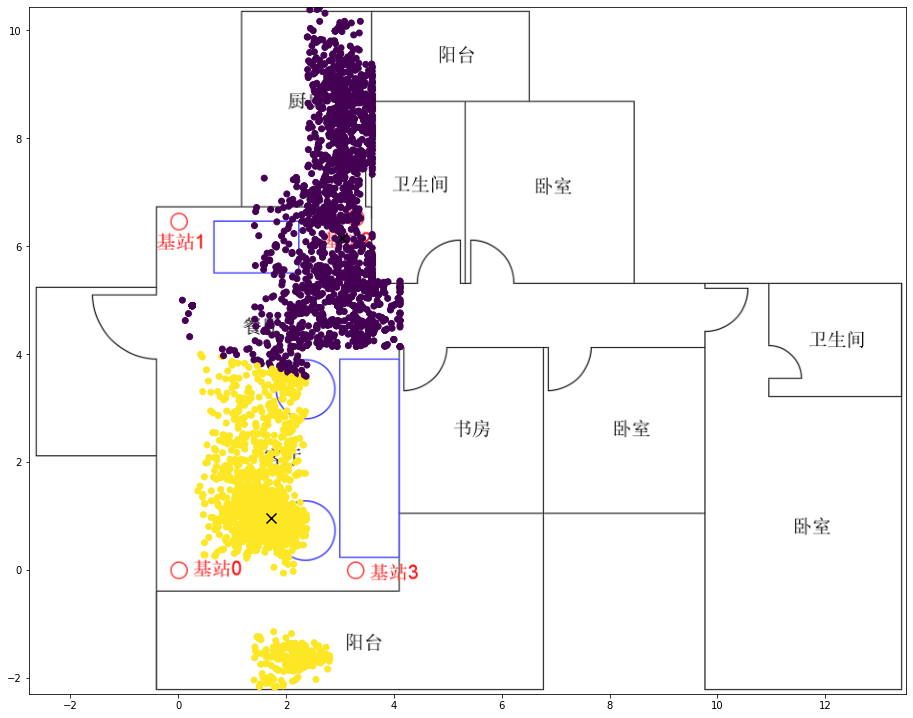

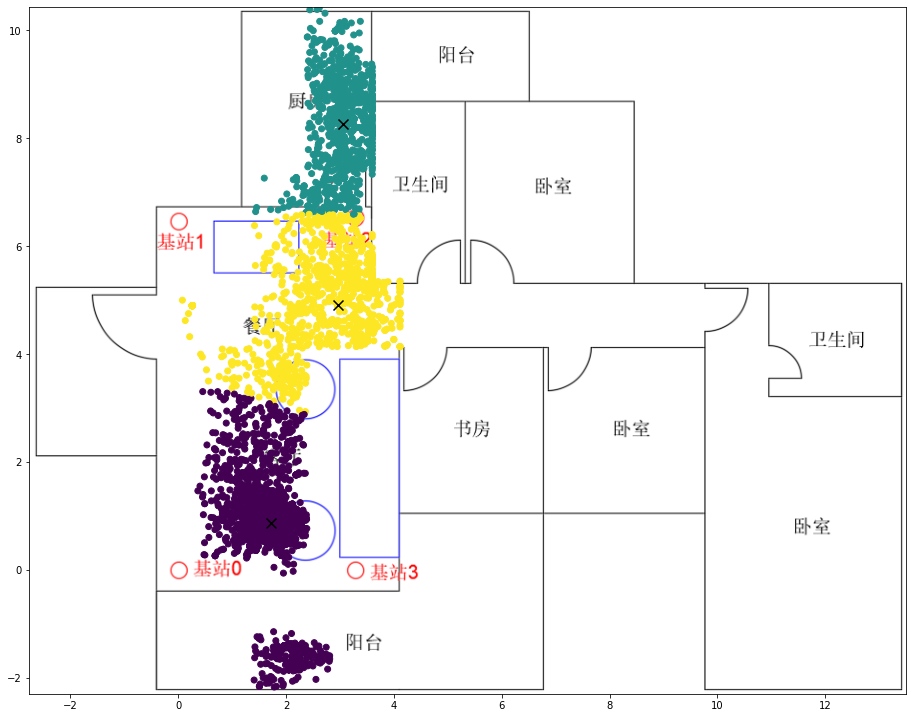

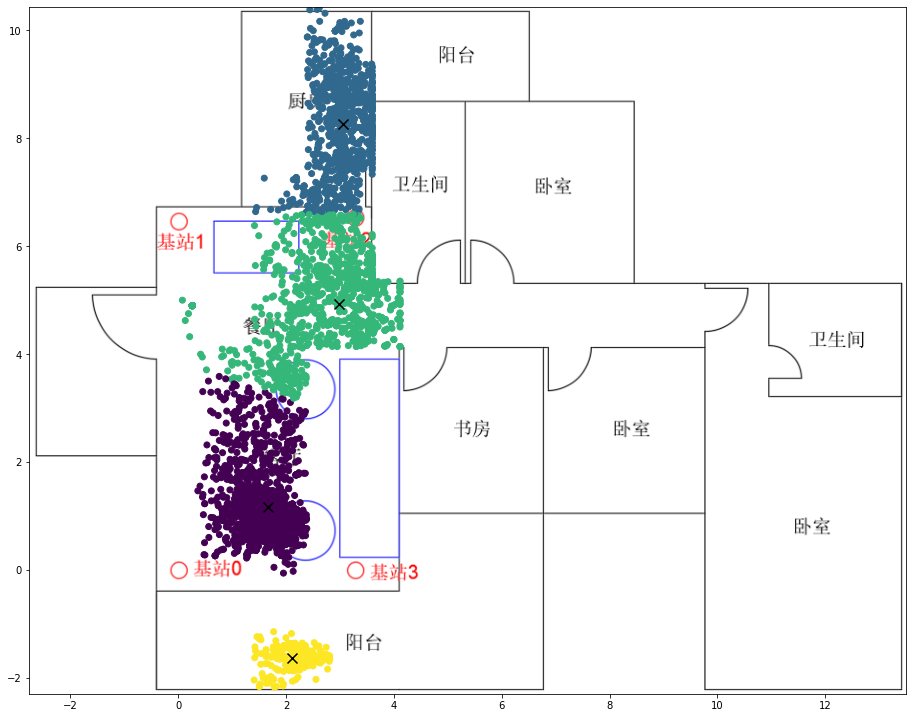

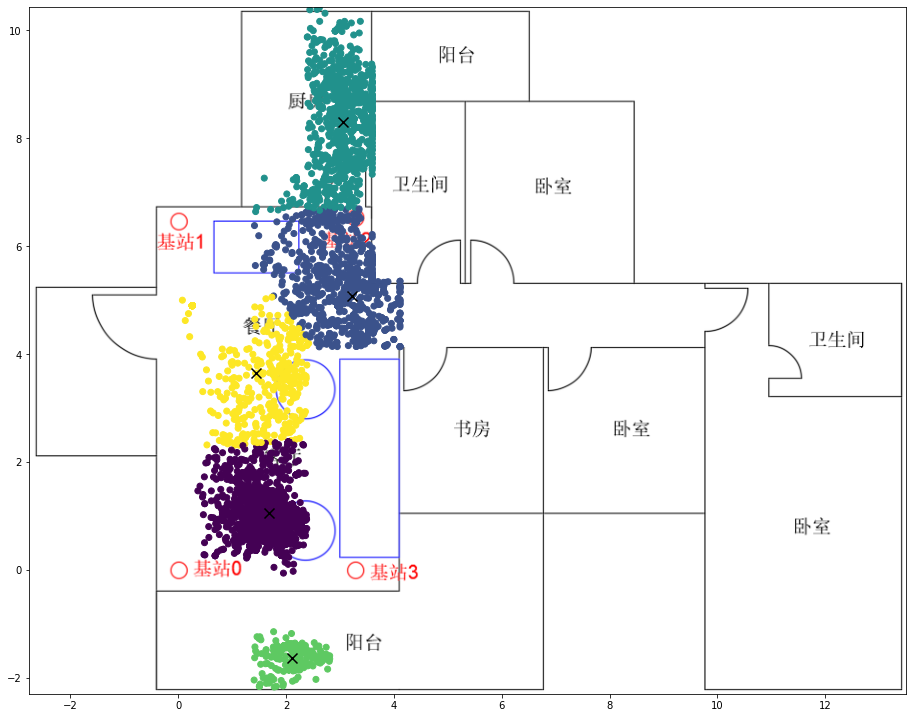

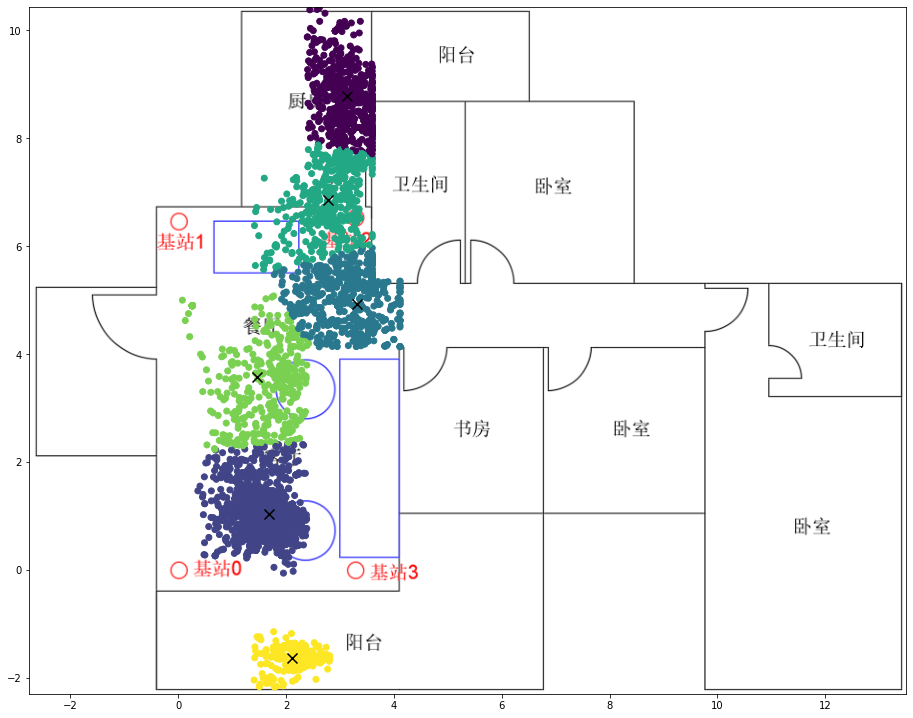

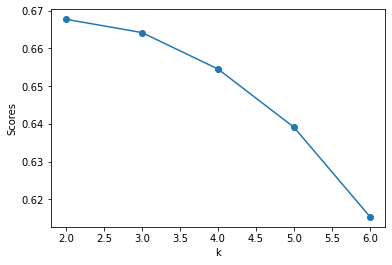

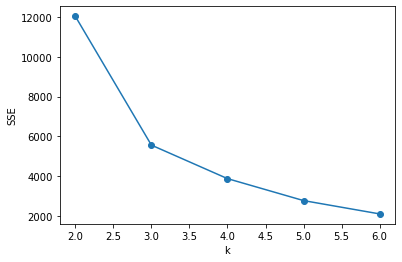

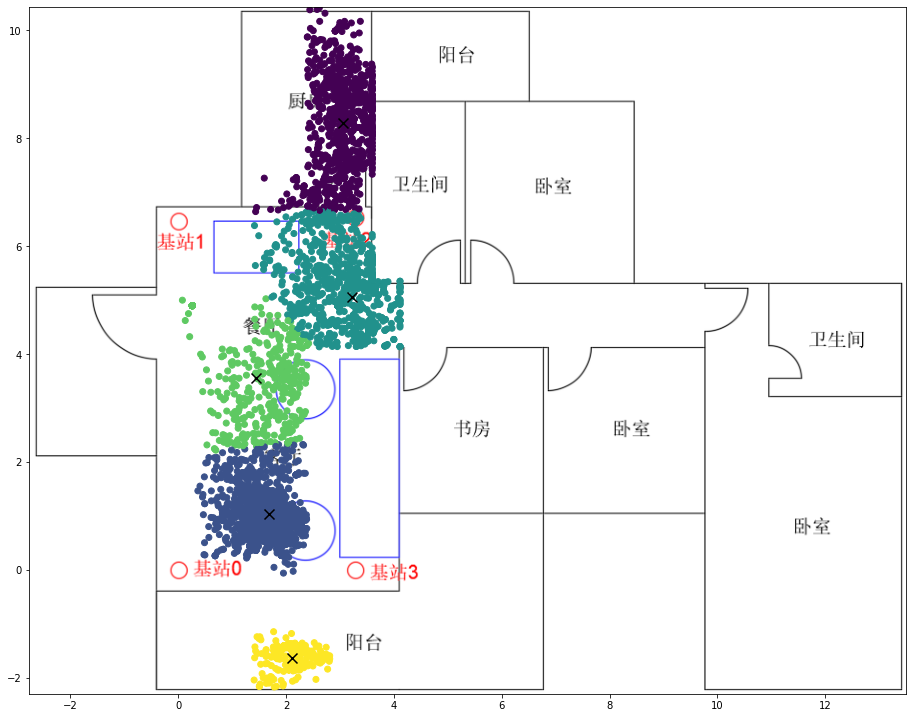

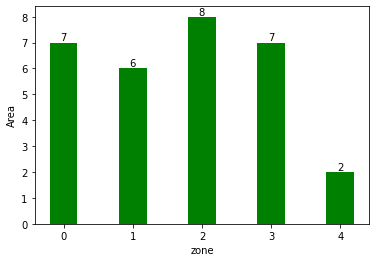

In [227]:
'''
整个14天的分区表示——聚类+画成热力图
'''
key="All"
data_allInOne = collectDataAllInOne(df_week)
groups,grids = createGrid(data_allInOne,key)
createHeatmap(grids,"heatmap_allInOne")

# create excel writer object 输出每个点对应的网格
writer = pd.ExcelWriter('output.xlsx')
# write dataframe to excel
data_allInOne.to_excel(writer)
# save the excel
writer.save()
    
 # 删去点数小于min_count的网格中的点——剩余的点更加集中，便于聚类
choice_data_all=choose_spots(data_allInOne,groups,40)
x=choice_data_all['x']
y=choice_data_all['y']
# centers: 聚类后每一类的中心点坐标——根据中心点划定zone的范围
centers_all,y_pre_all = K_m(x,y,key)
choice_data_all['zone']=y_pre_all


dict_zones_all= get_dict_zones(choice_data_all,number_cluster[key])
zones_info_forall=get_zone_info("All",dict_zones_all)
intervals_in_zones,details = getTimeIntervalsForZones(dict_zones_all,data_allInOne)

new_grids = createHeatmapByTime(dict_zones_all,"heatmap_allInOne")
createHeatmapByTime2(new_grids,"heatmap_allInOne")


In [228]:


'''
按在家时间长短分为两类分析
首先处理数据，将数据分为两类并整合
'''
    
list_long_df=[]
list_short_df=[]
list_mid_df=[]

for idx,row in totaltimes.iterrows():
    if row['TimeAtHome']>600: # 10h以上 长时间
        list_long_df.append(collectData(dict_df,row['date']))
    elif row['TimeAtHome']<300: # 5h以下 短时间
        list_short_df.append(collectData(dict_df,row['date']))
    else:
        list_mid_df.append(collectData(dict_df,row['date']))

df_long = pd.concat(list_long_df,sort=False)
df_long.reset_index(drop=True, inplace=True) 

df_short = pd.concat(list_short_df,sort=False)
df_short.reset_index(drop=True, inplace=True) 

df_mid = pd.concat(list_mid_df,sort=False)
df_mid.reset_index(drop=True, inplace=True) 


After Collect Data:
                    time         x         y
0   2022-02-07 08:29:00  3.054000  6.464179
1   2022-02-07 08:30:00  1.191444  5.549134
2   2022-02-07 08:31:00  2.466070  6.910877
3   2022-02-07 08:32:00  2.624581  6.069367
4   2022-02-07 08:33:00  1.871939  4.309019
..                  ...       ...       ...
839 2022-02-07 22:28:00  2.565653  4.496686
840 2022-02-07 22:29:00  2.286463  4.259578
841 2022-02-07 22:30:00  1.419988  1.377875
842 2022-02-07 22:31:00  1.631734  1.364558
843 2022-02-07 22:32:00  1.630561  1.725306

[844 rows x 3 columns]
After Collect Data:
                    time         x         y
0   2022-02-11 08:12:00  1.424158  2.969921
1   2022-02-11 08:13:00  2.830267  4.994131
2   2022-02-11 08:14:00  3.123333  5.240000
3   2022-02-11 08:15:00  3.123333  5.240000
4   2022-02-11 08:16:00  3.123333  5.240000
..                  ...       ...       ...
900 2022-02-11 23:12:00  1.891932  0.600085
901 2022-02-11 23:13:00  1.880769  0.614833
902 2022-0

                   time         x         y  label
0   2022-02-02 07:35:00  2.910135  7.072932    134
1   2022-02-02 07:36:00  2.657742  7.693834    150
2   2022-02-02 07:37:00  2.976735  7.566243    150
3   2022-02-02 07:38:00  2.660799  8.175517    150
4   2022-02-02 07:39:00  2.298434  7.753170    149
..                  ...       ...       ...    ...
647 2022-02-12 08:21:00  1.394646  2.528077     69
648 2022-02-12 08:22:00  1.363135  3.274217     84
649 2022-02-12 08:23:00  1.196387  1.577514     52
650 2022-02-12 08:24:00  1.469605  2.357517     69
651 2022-02-12 08:25:00  2.640049  4.624903    102

[652 rows x 4 columns]
0.8628321729141037
[0.8628321729141037, 0.79202258752845, 0.803727988574363, 0.4277334029903435, 0.4727114534479053]
2022-02-02 07:45:00 2022-02-02 07:35:00 0 days 00:10:00
2022-02-02 18:50:00 2022-02-02 08:00:00 0 days 10:50:00
2022-02-02 19:41:00 2022-02-02 18:55:00 0 days 00:46:00
2022-02-02 22:18:00 2022-02-02 19:44:00 0 days 02:34:00
2022-02-05 08:15:00 202

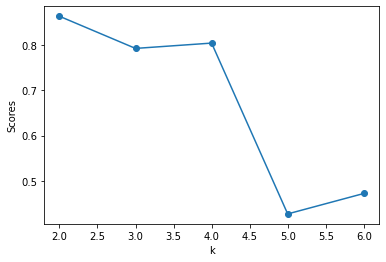

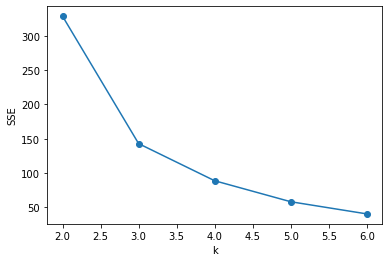

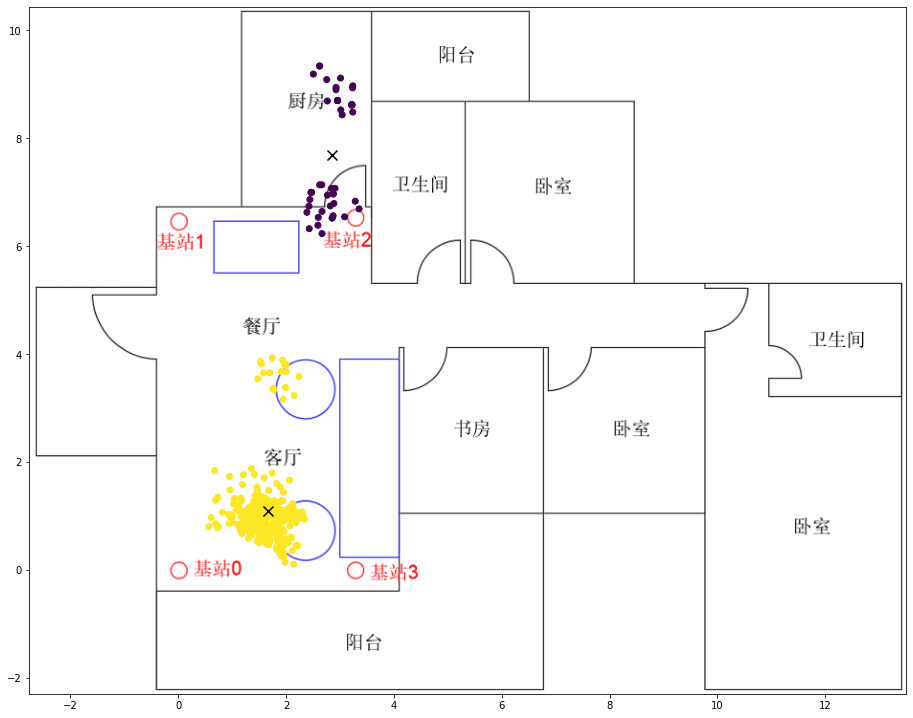

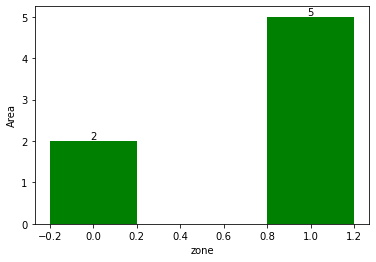

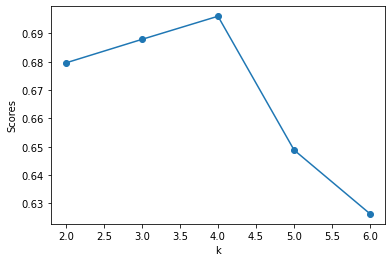

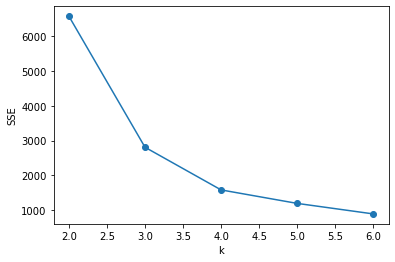

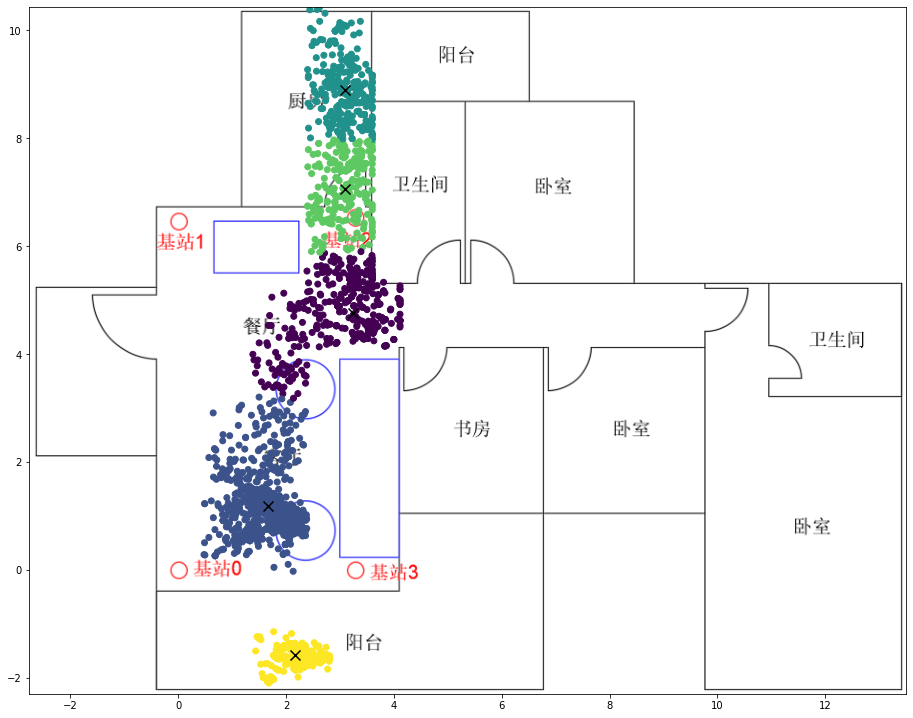

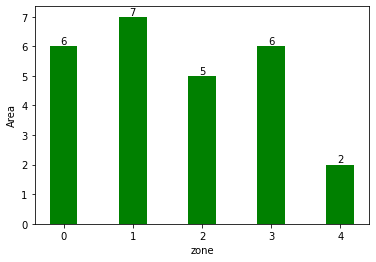

In [229]:
'''
短时段在家的情况：totaltimes[key]<300
'''
zones_info_short=FinalAnalysis(df_short,"short",len(list_short_df)*5)

'''
长时段在家的情况：totaltimes[key]>600
'''
zones_info_long=FinalAnalysis(df_long,"long",len(list_long_df)*5)

print("===========> DONE <===========")


                   time         x         y  label
0   2022-02-02 07:35:00  2.910135  7.072932    134
1   2022-02-02 07:36:00  2.657742  7.693834    150
2   2022-02-02 07:37:00  2.976735  7.566243    150
3   2022-02-02 07:38:00  2.660799  8.175517    150
4   2022-02-02 07:39:00  2.298434  7.753170    149
..                  ...       ...       ...    ...
647 2022-02-12 08:21:00  1.394646  2.528077     69
648 2022-02-12 08:22:00  1.363135  3.274217     84
649 2022-02-12 08:23:00  1.196387  1.577514     52
650 2022-02-12 08:24:00  1.469605  2.357517     69
651 2022-02-12 08:25:00  2.640049  4.624903    102

[652 rows x 4 columns]
0.8628321729141037
[0.8628321729141037, 0.79202258752845, 0.803727988574363, 0.42721778010999145, 0.4726066420529652]
2022-02-02 19:40:00 2022-02-02 19:21:00 0 days 00:19:00
2022-02-05 08:50:00 2022-02-02 23:04:00 2 days 09:46:00
2022-02-05 09:29:00 2022-02-05 09:18:00 0 days 00:11:00
2022-02-05 19:50:00 2022-02-05 09:30:00 0 days 10:20:00
2022-02-05 22:55:00 20

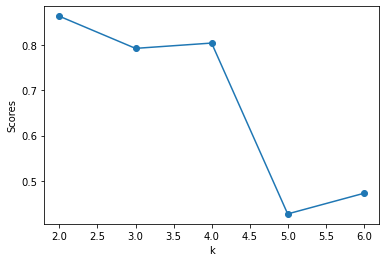

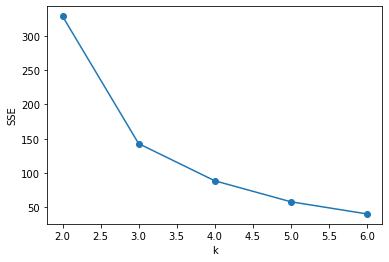

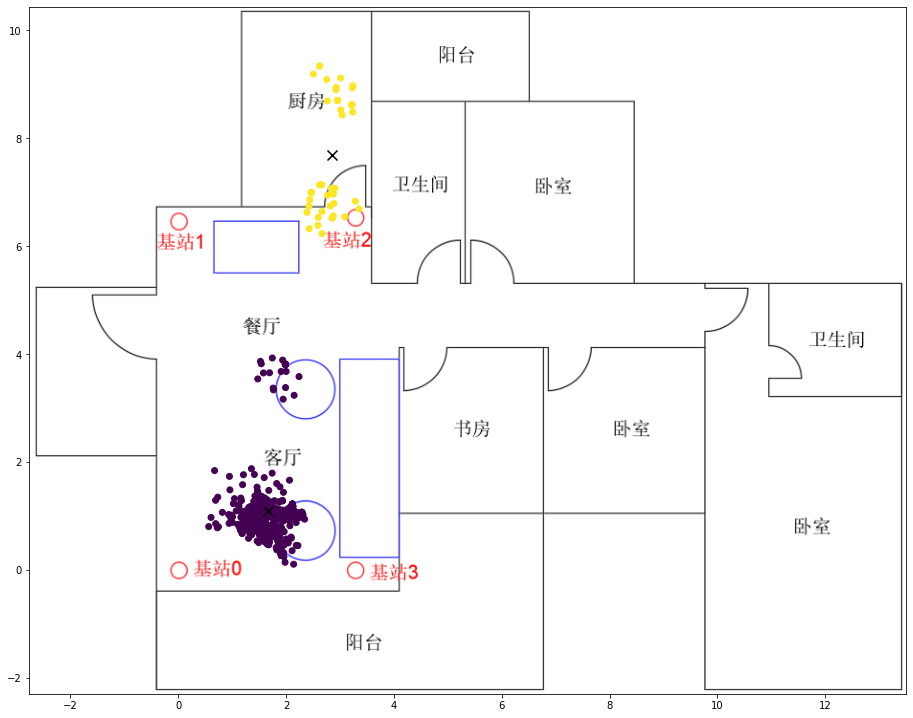

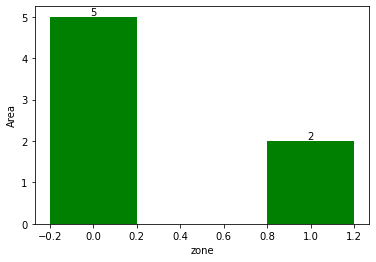

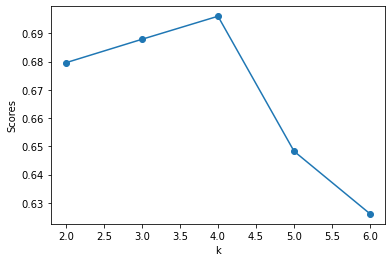

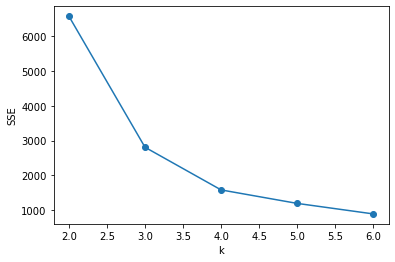

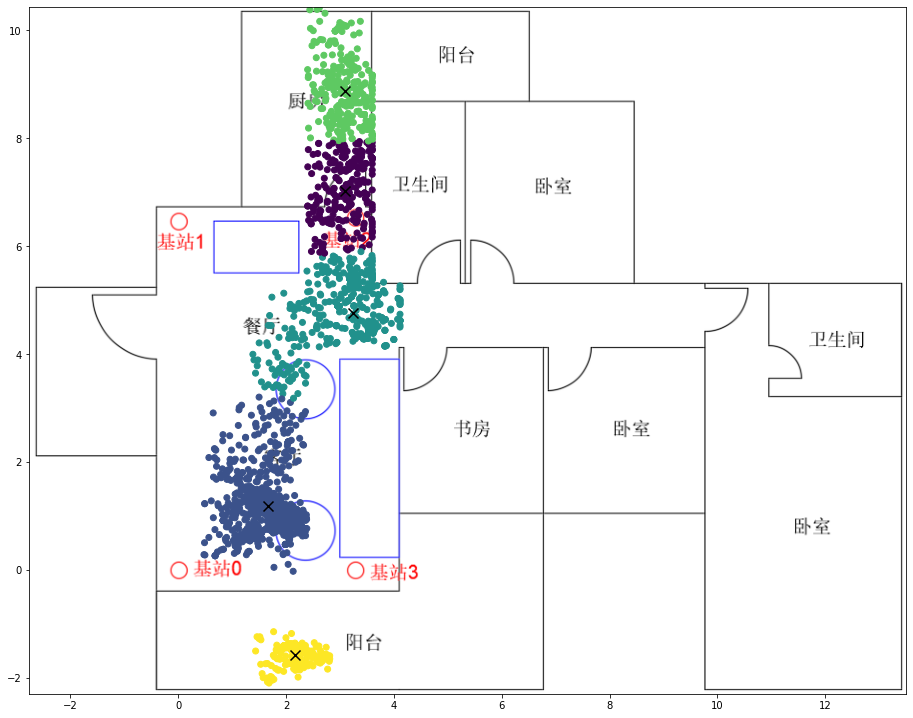

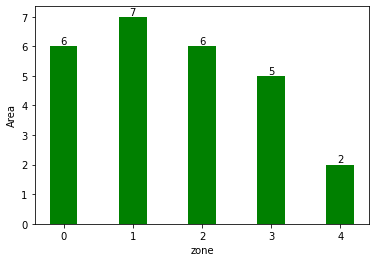

In [230]:

'''
短时段在家的情况：totaltimes[key]<300
'''
zones_info_short2=FinalAnalysis(df_short,"short",len(list_short_df)*5,withTimeLine=1)

'''
长时段在家的情况：totaltimes[key]>600
'''
zones_info_long2=FinalAnalysis(df_long,"long",len(list_long_df)*5,withTimeLine=1)

print("===========> DONE <===========")



In [1]:
'''
data:df_long  data_allInOne  [Dataframe]
zone_info: zones_info_long   zones_info_forall  [Dataframe]
[zone分区编号  labels(list)所含网格编号  Area]
'''
def stay_time(data,zone_info,key):
    # key:分区名称-value:对应的分区字典[key:时间段-value:出现的次数]
    dict_periods={}
    # 高于6分钟的时间段占总时间段的比例  All:所有时间段数量  MTS: 高于6分钟时间段的数量
    MTS_info=pd.DataFrame(columns=['zone','All','MTS','MTSPercentage'])
    for idx,row in zone_info.iterrows(): # 每个分区
        labels_now=row['labels'] # 分区所含的所有网格编号
        periods=[]  # 所有时间段
        
        count=0 # 计数 时间段长度
        for id,ro in data.iterrows():
            if ro['label'] in labels_now:
                count=count+1
            else:
                if count!=0:
                    periods.append(count)
                count=0
        set_periods=set(periods)
        dict={}
        for item in set_periods:
            dict.update({item:periods.count(item)}) # 某长度时间段出现的次数
        dict_periods.update({row['zone']:dict})

        # 画柱状图
        plt.figure()
        p1=plt.bar(list(dict.keys()),list(dict.values()) ,0.4,color="green")
        plt.bar_label(p1, label_type='edge',fontsize=12)
        plt.xlabel('Time interval/min')
        plt.ylabel('Counts')
        plt.savefig(res_path+key+"_zone="+str(row['zone'])+"_TimeIntervalCounts"+".png",dpi=300)

        # 计算数字特征
        MoreThanSix=0
        MTSlength=0
        AllPeriods=0
        Alllength=0
        for i in dict.keys():
            if int(i)>=6:
                MoreThanSix=MoreThanSix+dict[i]
                MTSlength=MTSlength+int(i)*dict[i]
            AllPeriods=AllPeriods+dict[i]
            Alllength=Alllength+int(i)*dict[i]
        MTSPercentage=MoreThanSix/AllPeriods
        print("zone:"+str(row['zone'])+":MTS="+str(MTSPercentage))

        
        newdf = pd.DataFrame({'zone':[ row['zone']],
        'All':[AllPeriods],
        'MTS':[MoreThanSix],
        'MTSPercentage':[MTSPercentage]})
        MTS_info=MTS_info.append(newdf,ignore_index=True)

    # 画MTS信息图
    # 绘柱状图
    plt.cla() #清空之前画的
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx() 
    
    x=list(MTS_info['zone'])
    y1=list(MTS_info['All'])
    y2=list(MTS_info['MTS'])
    y3=list(MTS_info['MTSPercentage'])
    
    ax1.bar(x, height=y1, label='All Periods',width = 0.5, facecolor='lightskyblue',edgecolor='white')
    ax1.bar(x, height=y2, label='Periods > 6min',width = 0.5, facecolor='steelblue',edgecolor='white')

    ax1.set_xlabel("zone")
    ax1.legend()
    
    # 画折线图
    ax2.plot(x, y3, "coral", ms=8, marker='*',label="MTS Percentage")
    # 在折线图上显示具体数值, ha参数控制水平对齐方式, va控制垂直对齐方式
    for x1, yy in zip(x, y3):
        ax2.text(x1, yy+0.02, str(round(yy, 3)), ha='center', va='bottom', fontsize=10, rotation=0)
    ax2.legend(loc="upper left")
    plt.savefig(res_path+key+"_MTSinfo"+".png",dpi=300)

    return dict_periods,MTS_info


periods_info_all,MTS_info_all=stay_time(data_allInOne,zones_info_forall,"All")
periods_info_long,MTS_info_long=stay_time(df_long,zones_info_long,"long")
periods_info_short,MTS_info_short=stay_time(df_short,zones_info_short,"short")

NameError: name 'data_allInOne' is not defined